# Build 3 Layer Network

- input layer
- 2 hidden layer
- output layer
<br>
<br>
- Loss function : Cross Entropy Error

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "4" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=np.inf)

## Define Functions

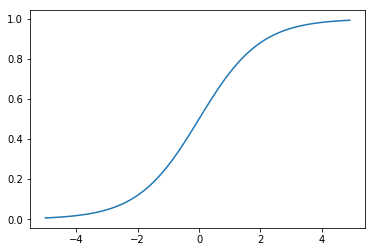

In [2]:
# sigmoid

def sigmoid(x):
    
    return 1 / (1 + np.exp(-x))

ex = np.arange(-5, 5, 0.1)
plt.plot(ex, sigmoid(ex))

In [3]:
# cross_entropy_error
# y : predicted value
# t : label

def cross_entropy_error(y, t):
    delta = 1e-7
    loss = -np.sum(t * np.log(y + delta))
    if y.ndim == 2:
        loss /= y.shape[0]
    return loss

y = np.random.rand(20, 10)
t = np.random.rand(20, 10)

cross_entropy_error(y, t)

6.01483155990713

In [4]:
# softmax
# x : input
# Overflow 방지 -> input 중 가장 큰 값 전체 데이터에서 빼주기

def softmax(x):
    c = x.max(axis=1, keepdims=True)
    x = x - c
    exp_x = np.exp(x)
    exp_x_sum = exp_x.sum(axis=1, keepdims=True)
    
    return  exp_x / exp_x_sum

softmax(y).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [5]:
# numerical_gradient
# 수치 미분법
# f : function
# x : variable
# 각 변수에 대한 편미분 저장된 배열 return

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] - float(tmp_val) + h
        fxh1 = f(x)
        
        x[idx] = float(tmp_val) - h
        fxh2 = f(x)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()
    
    return grad

## Define Network by Class

In [6]:
class ThreeLayerNet:
    # 초기화
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size, weight_init_std=0.01):
        
        # initialize parameters
        # W -> random 
        # b -> 0
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size_1)
        self.params['b1'] = np.zeros(hidden_size_1)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size_1, hidden_size_2)
        self.params['b2'] = np.zeros(hidden_size_2)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size_2, output_size)
        self.params['b3'] = np.zeros(output_size)
        
    # 예측 함수
    # x : 입력 데이터
    # y : 예측값
    def predict(self, x):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        
        a2 = np.dot(z1, W2) + b2
        z2 = sigmoid(a2)
        
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        
        return y
    
    
    # 손실 함수
    # cross_entropy_error 사용
    # x : 입력 데이터
    # t : 정답 레이블
    def loss(self, x, t):
        
        y = self.predict(x)
        return  cross_entropy_error(y, t)
    
    
    # 정확도 함수
    # x : 입력 데이터
    # t : 정답 레이블
    # x 중 예측값 == 정답 레이블 비율
    # accuracy = (정답 맞춘 데이터 수) / (전체 데이터 수)
    def accuracy(self, x, t):

        y = self.predict(x)
        batch_size = x.shape[0]
        correct = (y.argmax(1) == t.argmax(1)).sum()
        
        return  correct / batch_size
    
    
    # 기울기 함수
    # 수치 미분법으로 계산
    # x : 입력 데이터
    # t : 정답 레이블
    def gradient(self, x, t):
        # get loss function
        loss_W = lambda W: self.loss(x,t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        
        return grads

## train, test - MNIST

교재 github에서 /dataset/mnist.py 다운로드 후 load_mnist import해서 사용

**ThreeLayerNet으로 train, test**

- input_size = 784
- hidden_size_1 = 50
- hidden_size_2 = 100
- output_size = 10
- batch_size = 100
- learning_rate = 0.1
- iters_num = 5000
- train_size = x_train data 전체

**train loss 그래프 그리기**

In [18]:
from tqdm import tqdm

from mnist import load_mnist

# load dataset
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# Hyperparameters
#### 채워 넣으세요 ####
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = ThreeLayerNet(28*28, 64, 1, 10)

# 1 epoch 되는 iteration
iter_per_epoch = max(train_size/batch_size, 1)

# Train
for i in tqdm(range(iters_num)):
    # get minibatch
    # not random
    x_batch = x_train[i%train_size:i%train_size+batch_size]
    t_batch = t_train[i%train_size:i%train_size+batch_size]
    
    #### 채워 넣으세요 ####
    # gradient 계산 후 parameter update 필요
    grads = network.gradient(x_batch, t_batch)
    for key in grads.keys():
        network.params[key] -= learning_rate * grads[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 epoch 당 accuracy 계산
    if i%iter_per_epoch == 0:
        #### 채워 넣으세요 ####
        # train accuracy, test accuracy 각각 계산 후 (모델에서 정의한 accuracy 함수 이용)
        # train_acc_list, test_acc_list에 각각 accuracy append
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        
        print("Train Accuracy: " + str(train_acc) + " & " + "Test Accuracy: " + str(test_acc))


  0%|          | 0/120 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Visualize Loss
- loss 보여주는 plot

- 맘대로 시각화하면 됩니다

Text(0, 0.5, 'Accuracy')

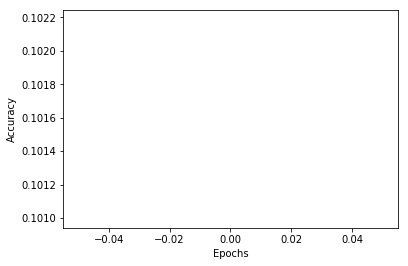

In [15]:
plt.figure()
plt.plot(train_acc_list, label="Train Acc")
plt.plot(test_acc_list, label="Test Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")